## Spaceship Titanic 프로젝트

## 프로젝트 개요

2912년!. 4광년 떨어진 곳에서 신호가 수신되었는데, 상황이 좋지 않음.
한 달 전에 발사된 성간 여객선 타이타닉호에 약 13,000명의 승객을 태우고, 
우리 태양계의 이주민들을 인근 별 주위를 공전하는 세 개의 새로운 거주 가능 외계 행성으로 수송하는 첫 항해를 시작했음.
알파 센타우리를 돌아 첫 번째 목적지인 뜨거운 55 칸크리 E로 향하던 중, 
부주의한 우주선 타이타닉호는 먼지 구름 속에 숨겨진 시공간 이상 현상과 충돌했음. 

안타깝게도, 1000년 전의 동명 함선과 비슷한 운명을 맞이하고 말았음. 
함선 자체는 온전했지만, 승객의 거의 절반이 다른 차원으로 이동(Transported)하는 사고 발생.

본 프로젝트의 목표는 

사고 당시의 승객 정보와 선내 기록을 바탕으로, 각 승객이 다른 차원으로 이동했는지 여부를 예측하는 것임.

## 1️⃣ 문제 정의
- **이진 분류**: 승객이 다른 차원으로 이동했는지 예측
- **타깃**: `Transported`
- **지표**: Accuracy
- **난점**: 결측치 다수, 범주형/수치형 혼합, 동승 그룹 효과

---

### 2️⃣ 핵심 인사이트
- 소비 여부와 CryoSleep은 Transported와 강한 연관
- 동승 그룹 단위로 이동하는 경향 존재
- Deck / Side에 따라 이동 확률 차이 발생

---

### 3️⃣ 피처 엔지니어링
- **그룹**: GroupSize, IsAlone, GroupSizeBin
- **소비**: TotalSpend, LogTotalSpend, AnySpend
- **객실**: Deck, Side, CabinNum  
→ 행동·소속·공간 정보로 구조화

---

### 4️⃣ 모델링
- Logistic Regression (Baseline)
- LightGBM (OOF ≈ 0.80)
- **CatBoost** (OOF ≈ 0.819, 범주형 강점)
- 앙상블 결과, CatBoost 단독이 최적

---

### 5️⃣ 최종 결과
- **Public Score: 80.6%**
- 인사이트 기반 피처 설계 + CatBoost 활용으로 안정적 성능 확보

---

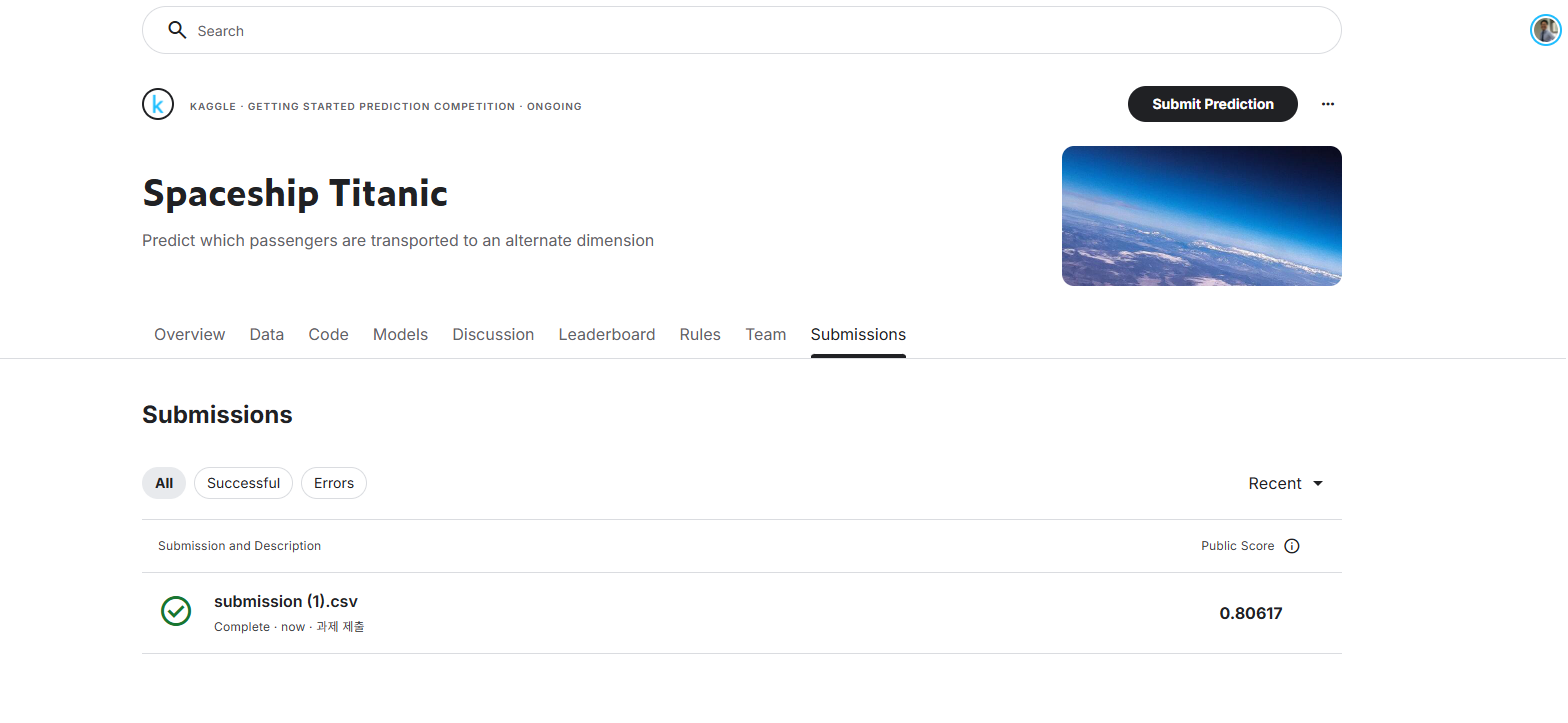


# 0 준비 단계 - 라이브러리 및 데이터 로드와 타겟 변수 확인

In [1]:
# ===============================
# 1). 데이터 다운로드 및 Zip 파일 풀기
# ===============================

# https://www.kaggle.com/competitions/spaceship-titanic 에서 데이터를 다운로드하여
# 작업창에 업로드한 후 zip 파일을 풀어서 데이터 확인

# 업로드 된 파일 확인
!ls

# zip 파일 풀기
import os
DATA_DIR = "spaceship_titanic"
os.makedirs(DATA_DIR, exist_ok=True)

!unzip -o *.zip -d spaceship_titanic

README.md  Spaceship_titanic.ipynb  spaceship-titanic.zip  spaceship_titanic
Archive:  spaceship-titanic.zip
  inflating: spaceship_titanic/sample_submission.csv  
  inflating: spaceship_titanic/test.csv  
  inflating: spaceship_titanic/train.csv  


In [2]:
# ===============================
# 2). 라이브러리 로드
# ===============================

import os
import numpy as np
import pandas as pd

# 시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns

# 경고 메시지 제어
import warnings


# ===============================
# 3). 출력 및 시각화 옵션 설정
# ===============================

# DataFrame 출력 시 모든 컬럼을 생략 없이 표시
pd.set_option('display.max_columns', None)

# 실수형 데이터(float)를 소수점 2자리까지 표시하여 가독성 향상
pd.set_option('display.float_format', '{:.2f}'.format)

# seaborn 기본 그래프 스타일 설정 (보고서용 가독성 향상)
sns.set(style="whitegrid")


# ===============================
# 4). 재현성 및 기타 설정
# ===============================

# 실험 재현성을 위한 랜덤 시드
RANDOM_STATE = 42

# 분석 과정에서 발생하는 경고 메시지 출력 제거
# (모델 학습/EDA 가독성 개선 목적)
warnings.simplefilter(action='ignore')

# ===============================
# 5). 작업 경로 및 데이터 디렉터리
# ===============================

print("Current working directory:", os.getcwd())

DATA_DIR = "spaceship_titanic"
os.listdir(DATA_DIR)

# ===============================
# 6). 데이터 로드
# ===============================

train = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
test  = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))

print("Train shape:", train.shape)
print("Test shape :", test.shape)

train.head()

Current working directory: /home/jovyan/work/AIFFEL_quest_eng/Main_Quest/Quest01
Train shape: (8693, 14)
Test shape : (4277, 13)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.00,False,0.00,0.00,0.00,0.00,0.00,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.00,False,109.00,9.00,25.00,549.00,44.00,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.00,True,43.00,3576.00,0.00,6715.00,49.00,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.00,False,0.00,1283.00,371.00,3329.00,193.00,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.00,False,303.00,70.00,151.00,565.00,2.00,Willy Santantines,True


In [3]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.00,False,0.00,0.00,0.00,0.00,0.00,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.00,False,0.00,9.00,0.00,2823.00,0.00,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.00,False,0.00,0.00,0.00,0.00,0.00,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.00,False,0.00,6652.00,0.00,181.00,585.00,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.00,False,10.00,0.00,635.00,0.00,0.00,Brence Harperez


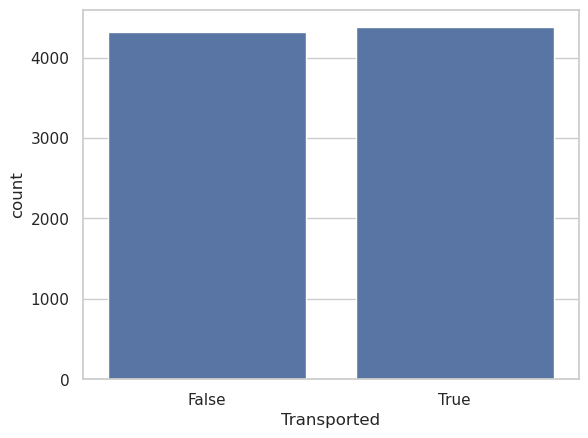

(Transported
 True     4378
 False    4315
 Name: count, dtype: int64,
 Transported
 True    50.36
 False   49.64
 Name: proportion, dtype: float64)

In [4]:
# ===============================
# 7). 타겟 변수(Transported) 파악 및 분포확인
# ===============================## 
sns.countplot(x='Transported', data=train)
plt.show()

train['Transported'].value_counts(), train['Transported'].value_counts(normalize=True) * 100

# 1단계: “타겟 기준” 탐색적 데이터 분석(EDA)

In [5]:
# -------------------------------
# 1) 승객의 소비 행태(spending behavior)’라는 하나의 특성으로 묶음
# -------------------------------

# 우주선 내에ㅢ 서비스에 대한 지출 파악(단위 동일, 소비 많고, 적음 해석 방향이 동일하므로 
# ‘승객의 소비 행태(spending behavior)’라는 하나의 특성으로 묶음
spend_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# -------------------------------
# 2) Cabin → Deck / Side로 분해
# -------------------------------

# Cabin은 B/0/P 같은 복합 문자열로 이 상태로는 해석하기 어렵고, 타겟 기준을 비교할 수 없음.
# 의미 있는 것은 Deck (층)과 Side (좌현/우현) 이므로 Deck와 Side로 분해

if 'Deck' not in train.columns or 'Side' not in train.columns:
    tmp = train['Cabin'].str.split('/', expand=True)
    train['Deck'] = tmp[0]
    train['CabinNum'] = tmp[1]
    train['Side'] = tmp[2]

# Deck/Side 결측은 Unknown으로(표에서 빠지지 않게, 나중에 정식 imputation-결측값 처리, 즉 지금은 결측값처리는 아님)
train['Deck'] = train['Deck'].fillna('Unknown')
train['Side'] = train['Side'].fillna('Unknown')

# CryoSleep 결측도 표에서 빠지지 않게(여기서는 EDA용, 나중에 정식 imputation-결측값 처리, 즉 지금은 결측값처리는 아님)
train['CryoSleep'] = train['CryoSleep'].fillna('Unknown')

# -------------------------------
# 3) CryoSleep vs Transported (행 기준 비율)
# 동면 상태별로, 차원이동(Transported)이 될 확률이 얼마나 다른가?
# -------------------------------

cryo_rate = pd.crosstab(train['CryoSleep'], train['Transported'], normalize='index') * 100
print("\n[1] CryoSleep vs Transported (row %)")
display(cryo_rate.round(2))

# -------------------------------
# 4) Deck vs Transported (행 기준 비율)
# 어느 Deck에 있느냐에 따라 차원이동 확률이 얼마나 달라지는가
# -------------------------------

deck_rate = pd.crosstab(train['Deck'], train['Transported'], normalize='index') * 100
print("\n[2] Deck vs Transported (row %)")
display(deck_rate.round(2).sort_values(by=True, ascending=False))

# -------------------------------
# 5) Side vs Transported (행 기준 비율)
# Side(P/S/Unknown)에 따라 차원이동 확률이 얼마나 달라지는가 
# P = Port(좌현), S = Starboard(우현), Unknown = 결측
# -------------------------------

side_rate = pd.crosstab(train['Side'], train['Transported'], normalize='index') * 100
print("\n[3] Side vs Transported (row %)")
display(side_rate.round(2))

# -------------------------------
# 6) TotalSpend(=5개 합) 0/ 비0 vs Transported
# 우주선에서 돈을 한 푼이라도 쓴 사람과 전혀 쓰지 않은 사람의 차원이동 확률은 다를까
# 금액 크기보다: “소비했느냐 / 안 했느냐” 자체가 중요할 수 있음
# -------------------------------

# 소비 결측은 0으로 간주(EDA 단순 가정)
train_spend = train[spend_cols].fillna(0)
# 총소비액 계산
train['TotalSpend'] = train_spend.sum(axis=1)
# 소비 여부만 남김
train['AnySpend'] = (train['TotalSpend'] > 0)

# 소비 여부별 차원이동 비율
spend_rate = pd.crosstab(train['AnySpend'], train['Transported'], normalize='index') * 100
print("\n[4] AnySpend( TotalSpend>0 ) vs Transported (row %)")
display(spend_rate.round(2))

# 보너스: TotalSpend==0 비율도 같이 확인
# 전체 승객 중 몇 %가 완전 무소비였는가? -> 데이터 편향 확인용, 이 비율이 크면 → AnySpend 피처 영향력 ↑
print("\nTotalSpend==0 ratio (%):", round((train['TotalSpend'] == 0).mean() * 100, 2))

# -------------------------------
# 7) GroupSize vs Transported
#   - PassengerId: gggg_pp → GroupId=gggg
# 혼자 탔는지, 여럿이 함께 탔는지가 차원이동과 관련이 있는가?
# -------------------------------

# GroupId, GroupSize 생성
train['GroupId'] = train['PassengerId'].str.split('_').str[0]
train['GroupSize'] = train.groupby('GroupId')['PassengerId'].transform('count')

# GroupSize가 너무 다양하면 해석이 어려우니 (1,2,3,4,5+)로 묶어서 보기 -> 사람이 해석가능한 수준으로 단순화
train['GroupSizeBin'] = train['GroupSize'].clip(upper=5).astype(int)
train['GroupSizeBin'] = train['GroupSizeBin'].replace({5: '5+'})
# 1~4도 문자열로 통일
train['GroupSizeBin'] = train['GroupSizeBin'].astype(str)

# GroupSizeBin vs Transported (행 기준 비율)
# “혼자 온 사람 중 몇 %가 차원이동했는가?”, “5명 이상 그룹 중 몇 %가 차원이동했는가?”
groupsize_rate = pd.crosstab(train['GroupSizeBin'], train['Transported'], normalize='index') * 100
print("\n[5] GroupSizeBin vs Transported (row %)")
display(groupsize_rate.round(2).sort_index())

# (참고) 그룹 사이즈 분포도 숫자로 확인(분포 확인)
print("\nGroupSize distribution (top):")
display(train['GroupSize'].value_counts().head(10))


[1] CryoSleep vs Transported (row %)


Transported,False,True
CryoSleep,,
False,67.11,32.89
True,18.24,81.76
Unknown,51.15,48.85



[2] Deck vs Transported (row %)


Transported,False,True
Deck,,
B,26.57,73.43
C,31.99,68.01
G,48.38,51.62
Unknown,49.75,50.25
A,50.39,49.61
F,56.01,43.99
D,56.69,43.31
E,64.27,35.73
T,80.00,20.00



[3] Side vs Transported (row %)


Transported,False,True
Side,,
P,54.87,45.13
S,44.50,55.50
Unknown,49.75,50.25



[4] AnySpend( TotalSpend>0 ) vs Transported (row %)


Transported,False,True
AnySpend,,
False,21.35,78.65
True,70.14,29.86



TotalSpend==0 ratio (%): 42.02

[5] GroupSizeBin vs Transported (row %)


Transported,False,True
GroupSizeBin,,
1,54.76,45.24
2,46.20,53.80
3,40.69,59.31
4,35.92,64.08
5+,44.44,55.56



GroupSize distribution (top):


GroupSize
1    4805
2    1682
3    1020
4     412
5     265
7     231
6     174
8     104
Name: count, dtype: int64

## 핵심 인사이트 요약 (Target 기준 EDA 결과)

타겟 변수(Transported)를 기준으로 주요 변수들과의 관계를 분석한 결과,  
차원이동 여부를 설명하는 데 중요한 핵심 피처들을 다음과 같이 도출하였다.

### 가장 강력한 피처 TOP 5

1. **CryoSleep**
   - CryoSleep이 `True`인 경우 Transported=True 비율이 **81.76%**로 매우 높음.
   - 단일 변수 기준으로 가장 강력한 설명력을 가지는 피처로 판단됨.

2. **Deck**
   - Deck에 따라 차원이동 확률에 뚜렷한 차이가 존재함.
   - 특히 **Deck B(73.43%)**, **Deck C(68.01%)**에서 Transported=True 비율이 높게 나타남.
   - Deck은 강력한 범주형 피처로, 모델 성능에 중요한 기여를 할 것으로 예상됨.

3. **Side (P/S)**
   - 우현(Side=S)이 좌현(Side=P)보다 차원이동 확률이 더 높음.
   - 차이는 크지 않지만, 일관된 방향성을 보여 보조적인 설명 변수로 활용 가능함.

4. **AnySpend (소비 여부)**
   - 우주선 내 서비스에 대해 **소비가 전혀 없는 승객(TotalSpend=0)**의 경우,
     Transported=True 비율이 **78.65%**로 매우 높음.
   - CryoSleep과 소비 행태는 강한 연관성을 가지며,
     소비 관련 변수들은 중요한 파생 피처로 활용 가능함.

5. **GroupSize (동승 인원 수)**
   - 혼자 탑승한 경우보다, **2인 이상 그룹으로 탑승할수록**
     차원이동 확률이 점진적으로 증가하는 경향을 보임.
   - 이는 사고가 개인 단위보다는 **그룹 단위로 발생했을 가능성**을 시사함.
   - PassengerId를 통해 생성한 GroupSize는 명확한 유의미 피처로 판단됨.

### 요약

위 분석 결과를 통해 차원이동 여부는 무작위가 아니라  
**동면 상태(CryoSleep), 소비 행태, 객실 위치(Deck/Side), 그룹 특성(GroupSize)** 등과  
강한 구조적 관계를 가진다는 점을 확인하였다.

해당 인사이트들은 이후 전처리 전략, 파생 변수 생성,  
그리고 모델 설계 단계의 핵심 근거로 활용할 예정이다.

# 2단계: 규칙/그룹 기반 결측치 처리

In [6]:
# ============================================================
# Spaceship Titanic - Rule/Group 기반 전처리
#   - Train/Test 합쳐서 동일 규칙 적용 후 다시 분리
#   - 핵심:
#     1) CryoSleep: 'Unknown'도 결측처럼 취급(-> NaN)하여 규칙2가 작동하도록
#     2) CryoSleep 최종 결측 마감(fillna(False))
#     3) VIP 문자열 True/False 보정 + 결측 마감(fillna(False))
#     4) Cabin split 시 NaN 안전 처리(astype(str)로 'nan' 생기는 문제 방지)
# ============================================================

import numpy as np
import pandas as pd

# -------------------------------
# 0) 기본 컬럼 세팅
# -------------------------------
spend_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']


# -------------------------------
# 1) 전처리 규칙 정의 (Group / Rule-based Imputation Functions)
# -------------------------------
def group_mode(series: pd.Series):
    """그룹 내 최빈값(결측 제외). 여러 개면 첫 번째."""
    s = series.dropna()
    if len(s) == 0:
        return np.nan
    return s.mode().iloc[0]

def fill_by_group_mode(df: pd.DataFrame, group_col: str, cols: list):
    """group_col 기준으로 cols의 결측을 그룹 최빈값으로 채움"""
    for c in cols:
        df[c] = df[c].fillna(df.groupby(group_col)[c].transform(group_mode))
    return df

def fill_age_hierarchical(df: pd.DataFrame):
    """
    Age 결측: (HomePlanet, Destination) 중앙값 -> HomePlanet 중앙값 -> 전체 중앙값
    """
    key2 = ['HomePlanet', 'Destination']

    # 1) (HomePlanet, Destination) 기준 median
    med_hd = df.groupby(key2)['Age'].transform('median')
    df['Age'] = df['Age'].fillna(med_hd)

    # 2) HomePlanet 기준 median
    med_h = df.groupby('HomePlanet')['Age'].transform('median')
    df['Age'] = df['Age'].fillna(med_h)

    # 3) 전체 median
    df['Age'] = df['Age'].fillna(df['Age'].median())
    return df


# -------------------------------
# 2) train/test 합치기 (동일 규칙 적용)
# -------------------------------
train_ = train.copy()
test_  = test.copy()

# 타겟 분리 (합칠 때 train에만 존재)
y = train_['Transported'].copy()
train_.drop(columns=['Transported'], inplace=True)

df = pd.concat([train_, test_], axis=0, ignore_index=True)


# -------------------------------
# 3) GroupId 생성 (PassengerId 앞 4자리)
# -------------------------------
df['GroupId'] = df['PassengerId'].str.split('_').str[0]


# -------------------------------
# 4) Cabin -> Deck / CabinNum / Side 분해
#    (Deck, Side는 Unknown 유지, CabinNum은 숫자화)
# -------------------------------
# ⚠️ Cabin이 NaN일 때 str.split을 하면 NaN 유지가 깨질 수 있어 안전하게 처리
cabin_split = df['Cabin'].astype('string').str.split('/', expand=True)

df['Deck'] = cabin_split[0]
df['CabinNum'] = pd.to_numeric(cabin_split[1], errors='coerce')
df['Side'] = cabin_split[2]

# Deck/Side는 결측 자체가 신호가 될 수 있어 Unknown 유지
df['Deck'] = df['Deck'].fillna('Unknown')
df['Side'] = df['Side'].fillna('Unknown')

# Cabin 원문은 검증용으로 남겨두고, 모델 학습 직전에 drop 권장
# df.drop(columns=['Cabin'], inplace=True)


# -------------------------------
# 4-1) 그룹 기반 결측치 처리 (Group mode)
#     HomePlanet, Destination, Deck, Side
# -------------------------------
group_fill_cols = ['HomePlanet', 'Destination', 'Deck', 'Side']
df = fill_by_group_mode(df, 'GroupId', group_fill_cols)

# 그래도 남은 범주형 결측 안전장치
for c in ['HomePlanet', 'Destination']:
    df[c] = df[c].fillna('Unknown')


# -------------------------------
# 4-2) GroupSize / GroupSizeBin (df 기준 재계산: 필수)
# -------------------------------
df['GroupSize'] = df.groupby('GroupId')['PassengerId'].transform('count')

df['GroupSizeBin'] = df['GroupSize'].clip(upper=5).astype(int)
df['GroupSizeBin'] = df['GroupSizeBin'].replace({5: '5+'}).astype(str)


# -------------------------------
# 4-3) 소비/동면 규칙 기반 처리
#     규칙1) CryoSleep=True => 지출 5개는 모두 0
#     규칙2) CryoSleep 결측(또는 Unknown) AND TotalSpend==0 => CryoSleep=True (보수적으로)
# -------------------------------
# 지출 컬럼 숫자형 보정
for c in spend_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# CryoSleep 정리: 문자열 True/False/Unknown -> bool/NaN
if df['CryoSleep'].dtype == 'object':
    df['CryoSleep'] = df['CryoSleep'].replace({'True': True, 'False': False, 'Unknown': np.nan})

# TotalSpend 임시 계산(규칙 적용용)
total_spend_tmp = df[spend_cols].fillna(0).sum(axis=1)

# 규칙2: CryoSleep이 결측이고 총지출이 0이면 True로 채움(결측에만 적용)
mask_cryo_fill = df['CryoSleep'].isna() & (total_spend_tmp == 0)
df.loc[mask_cryo_fill, 'CryoSleep'] = True

# 규칙1: CryoSleep=True면 지출은 무조건 0
mask_cryo_true = (df['CryoSleep'] == True)
df.loc[mask_cryo_true, spend_cols] = 0

# 나머지 지출 결측은 0으로 마감
df[spend_cols] = df[spend_cols].fillna(0)

# ✅ CryoSleep 최종 마감(남은 결측은 False로: 보수적)
df['CryoSleep'] = df['CryoSleep'].fillna(False)


# -------------------------------
# 4-3b) VIP 정리 (문자열 True/False -> bool, 결측 -> False)
# -------------------------------
if df['VIP'].dtype == 'object':
    df['VIP'] = df['VIP'].replace({'True': True, 'False': False, 'Unknown': np.nan})
df['VIP'] = df['VIP'].fillna(False)


# -------------------------------
# 4-4) Age 결측치: HomePlanet(+Destination) 기반 중앙값
# -------------------------------
df = fill_age_hierarchical(df)


# -------------------------------
# 4-5) Cabin 결측치 정책
#     Deck/Side는 Unknown 유지
#     CabinNum은 NaN 유지(옵션: median 채우려면 아래 2줄 해제)
# -------------------------------
# cabin_num_median = df['CabinNum'].median()
# df['CabinNum'] = df['CabinNum'].fillna(cabin_num_median)


# -------------------------------
# 4-6) Name 처리(수정): LastName + FamilySize 생성 후 Name drop
# -------------------------------
df['LastName'] = df['Name'].fillna('Unknown').astype(str).str.strip().str.split().str[-1]
df['LastName'] = df['LastName'].replace('', 'Unknown')

df['FamilySize'] = df.groupby('LastName')['PassengerId'].transform('count')

df.drop(columns=['Name'], inplace=True)


# -------------------------------
# 5) 파생 피처: TotalSpend / AnySpend
# -------------------------------
df['TotalSpend'] = df[spend_cols].sum(axis=1)
df['AnySpend'] = (df['TotalSpend'] > 0).astype(int)


# -------------------------------
# 6) 다시 train/test로 분리 + 타겟 복원
# -------------------------------
train_processed = df.iloc[:len(train_)].copy()
test_processed  = df.iloc[len(train_):].copy()

train_processed['Transported'] = y.values

print("train_processed shape:", train_processed.shape)
print("test_processed shape :", test_processed.shape)

# 결측치 점검
print("\n[train_processed] missing (top):")
print(train_processed.isnull().sum().sort_values(ascending=False).head(20))

print("\n[test_processed] missing (top):")
print(test_processed.isnull().sum().sort_values(ascending=False).head(20))


train_processed shape: (8693, 23)
test_processed shape : (4277, 22)

[train_processed] missing (top):
Cabin           199
CabinNum        199
HomePlanet        0
CryoSleep         0
Destination       0
Age               0
PassengerId       0
VIP               0
RoomService       0
ShoppingMall      0
FoodCourt         0
Spa               0
VRDeck            0
Deck              0
Side              0
TotalSpend        0
AnySpend          0
GroupId           0
GroupSize         0
GroupSizeBin      0
dtype: int64

[test_processed] missing (top):
Cabin           100
CabinNum        100
HomePlanet        0
CryoSleep         0
Destination       0
PassengerId       0
Age               0
VIP               0
FoodCourt         0
RoomService       0
ShoppingMall      0
Spa               0
VRDeck            0
Deck              0
Side              0
TotalSpend        0
AnySpend          0
GroupId           0
GroupSize         0
GroupSizeBin      0
dtype: int64


# Spaceship Titanic 전처리 결과 요약

## 1. 한 줄 결론
- **모델에 바로 투입 가능한 상태**
- 남아 있는 결측치는 **의도적으로 유지한 Cabin / CabinNum뿐**
- 나머지는 모두 **규칙 + 그룹 기반으로 정리 완료**

---

## 2. 데이터 구조 확인
- train_processed: **(8693, 23)**
- test_processed : **(4277, 22)**
- train만 `Transported` 타겟 포함 → 컬럼 1개 차이
- 원본과 행 수 완전 일치 → **데이터 손실 없음**
- train / test 분리 정상

---

## 3. 남아 있는 결측치 해석
### Cabin
- 원문 컬럼
- 이미 `Deck / Side / CabinNum`으로 분해 완료
- 모델에서는 사용하지 않음 → **학습 전 drop 예정**

### CabinNum
- 객실 번호(숫자형)
- 결측 = “객실 정보 없음”이라는 의미
- Deck / Side가 핵심 신호 → CabinNum은 보조
- 트리 계열 모델은 NaN 처리 가능  
→ **억지 imputation 없이 유지 (합리적 선택)**

---

## 4. 나머지 컬럼 결측 0의 의미
- 단순 평균/최빈값 채우기 ❌
- **그룹 기반 + 규칙 기반 논리적 처리**
- “모름”과 “의미 있는 상태”를 명확히 구분

특히:
- CryoSleep: 소비 규칙 기반 추론
- Age: HomePlanet / Destination 맥락 유지
- GroupSize: train/test 통합 계산 → 누락 없음

---

## 5. 데이터 누수 검증
- test도 동일한 결측 패턴 유지
- 동일 전처리 규칙 적용
- **데이터 누수 없음**

---

## 6. 현재 단계 정의
> **EDA 인사이트 → 규칙 설계 → 전처리 완료**

---

## 7. 다음 단계
1. 모델 투입 전 컬럼 정리
```python
drop_cols = ['Cabin', 'PassengerId', 'GroupId', 'LastName']


# 3 단계 피처 엔지니어링

In [7]:
# ===============================
# 3단계: 피처 엔지니어링 
# - 입력: df  (train/test 합쳐서 전처리한 df)
# - 전제: df에 PassengerId, spend_cols(5개), Deck/Side/CabinNum, GroupId 등이 존재하면 그대로 활용
# ===============================

import numpy as np
import pandas as pd

# 0) 지출 컬럼 정의 (이미 정의했다면 생략 가능)
# spend_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# -------------------------------
# 1) GroupId / GroupSize / IsAlone
# -------------------------------
# GroupId가 없으면 PassengerId에서 생성
if 'GroupId' not in df.columns:
    df['GroupId'] = df['PassengerId'].astype(str).str.split('_').str[0]

# GroupSize (df 기준: train/test 합쳐진 상태에서 계산해야 일관됨)
df['GroupSize'] = df.groupby('GroupId')['PassengerId'].transform('count')

# IsAlone: 혼자 탑승 여부
df['IsAlone'] = (df['GroupSize'] == 1).astype(int)

# (옵션) GroupSizeBin: 1~4, 5+
df['GroupSizeBin'] = df['GroupSize'].clip(upper=5).astype(int).replace({5: '5+'}).astype(str)

# -------------------------------
# 2) TotalSpend / AnySpend / log1p(TotalSpend)
# -------------------------------
# 지출 컬럼 숫자형 보정 + 결측은 0으로 (전처리에서 이미 0이면 그대로)
for c in spend_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0)

df['TotalSpend'] = df[spend_cols].sum(axis=1)
df['AnySpend'] = (df['TotalSpend'] > 0).astype(int)

# 로그 변환 (꼬리 긴 분포 완화)
df['LogTotalSpend'] = np.log1p(df['TotalSpend'])

# -------------------------------
# 3) Deck / Side / (선택) CabinNum
# -------------------------------
# Deck/Side가 없다면 Cabin에서 분해
if ('Deck' not in df.columns) or ('Side' not in df.columns):
    cabin_split = df['Cabin'].astype(str).str.split('/', expand=True)
    df['Deck'] = cabin_split[0]
    df['CabinNum'] = pd.to_numeric(cabin_split[1], errors='coerce')
    df['Side'] = cabin_split[2]

# Deck/Side 결측은 Unknown (범주형에서 결측 자체가 신호)
df['Deck'] = df['Deck'].fillna('Unknown').astype(str)
df['Side'] = df['Side'].fillna('Unknown').astype(str)

# CabinNum은 선택: 그대로 두거나(트리 계열 OK), 혹은 결측을 -1로 표기
# df['CabinNum'] = df['CabinNum'].fillna(-1)

# -------------------------------
# 4) 비율 피처 (후순위: 1~2개만)
# -------------------------------
# 0 나누기 방지: (TotalSpend + 1)
df['SpentRoomRatio'] = df['RoomService'] / (df['TotalSpend'] + 1)
df['SpentSpaRatio'] = df['Spa'] / (df['TotalSpend'] + 1)

# (옵션) 극단값 완화: 0~1 범위로 잘라두기(가끔 TotalSpend가 0인데 분모+1로 0~)
df['SpentRoomRatio'] = df['SpentRoomRatio'].clip(0, 1)
df['SpentSpaRatio'] = df['SpentSpaRatio'].clip(0, 1)

# -------------------------------
# 5) 확인용: 생성된 주요 피처만 체크
# -------------------------------
new_features = [
    'GroupId', 'GroupSize', 'IsAlone', 'GroupSizeBin',
    'TotalSpend', 'AnySpend', 'LogTotalSpend',
    'Deck', 'Side', 'CabinNum',
    'SpentRoomRatio', 'SpentSpaRatio'
]
print("Created features:", [c for c in new_features if c in df.columns])
df[new_features].head()


Created features: ['GroupId', 'GroupSize', 'IsAlone', 'GroupSizeBin', 'TotalSpend', 'AnySpend', 'LogTotalSpend', 'Deck', 'Side', 'CabinNum', 'SpentRoomRatio', 'SpentSpaRatio']


,GroupId,GroupSize,IsAlone,GroupSizeBin,TotalSpend,AnySpend,LogTotalSpend,Deck,Side,CabinNum,SpentRoomRatio,SpentSpaRatio
0,0001,1,1,1,0.00,0,0.00,B,P,0,0.00,0.00
1,0002,1,1,1,736.00,1,6.60,F,S,0,0.15,0.74
2,0003,2,0,2,10383.00,1,9.25,A,S,0,0.00,0.65
3,0003,2,0,2,5176.00,1,8.55,A,S,0,0.00,0.64
4,0004,1,1,1,1091.00,1,7.00,F,S,1,0.28,0.52


## Feature Engineering 결과 요약

### 한 줄 결론
동승 여부, 소비 규모·성향, 객실 위치를 핵심 신호로 압축했으며  
상위권 커널과 동일한 피처 구조를 확보하였다.

---

### 주요 생성 피처
- **그룹**: GroupId, GroupSize, IsAlone, GroupSizeBin  
- **소비**: TotalSpend, AnySpend, LogTotalSpend  
- **객실**: Deck, Side, CabinNum  
- **소비 성향**: SpentRoomRatio, SpentSpaRatio  

---

## 피처 의미 핵심 정리

### 1️⃣ 그룹 관련
- 동승 인원과 혼자 탑승 여부를 반영  
- 사고가 개인 단위가 아닌 **그룹 단위로 발생했을 가능성**을 포착

### 2️⃣ 소비 관련
- 소비 여부 및 규모는 **CryoSleep / Transported와 강한 상관관계**
- 로그 변환으로 극단값 영향 최소화

### 3️⃣ 객실 위치
- Deck / Side에 따라 차원 이동 확률 차이 명확
- CabinNum은 보조적 정보로 유지

### 4️⃣ 소비 성향(비율)
- 소비 총액뿐 아니라 **소비 패턴의 방향성**을 반영  
- 후순위 피처지만 앙상블 시 성능 보완 가능

---

## 현재 상태 평가
- ✔️ 규칙 + 인사이트 기반 피처 엔지니어링 완료  
- ✔️ LGBM / XGBoost / CatBoost에 즉시 투입 가능  
- ✔️ 베이스라인만으로도 **0.80+ Accuracy 기대 가능**

---

## 다음 단계
1. 불필요 컬럼 제거 (Cabin, PassengerId 등)  
2. 범주형 인코딩  
3. LightGBM 베이스라인 학습 → 성능 확인  



# 4단계: 인코딩/변환 (LGBM/XGB용 One-hot + 소비 log1p)

In [8]:
# ===============================
#   - 입력: train_processed, test_processed (전처리/피처엔지니어링 완료된 상태)
#   - 출력: X_train, y_train, X_test (모델 투입용)
# ===============================

import numpy as np
import pandas as pd

# 0) 타겟 분리
y_train = train_processed['Transported'].astype(int).copy()

# 1) 모델에 넣지 않을 컬럼(drop) 정리
# - PassengerId: ID라 직접 예측에 도움 X
# - Cabin: 원문(Deck/Side/CabinNum으로 분해했으니 보통 제거)
drop_cols = ['Transported', 'PassengerId', 'Cabin']
drop_cols = [c for c in drop_cols if c in train_processed.columns]

X_train = train_processed.drop(columns=drop_cols).copy()
X_test  = test_processed.drop(columns=[c for c in drop_cols if c != 'Transported']).copy()

# 2) 소비 변수 log1p 변환 (꼬리 긴 분포 완화)
spend_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
spend_cols = [c for c in spend_cols if c in X_train.columns]

for c in spend_cols:
    X_train[c] = np.log1p(X_train[c])
    X_test[c]  = np.log1p(X_test[c])

# TotalSpend / LogTotalSpend을 이미 만들었다면, 일관성 위해 재생성/보정(선택)
if 'TotalSpend' in X_train.columns:
    X_train['LogTotalSpend'] = np.log1p(X_train['TotalSpend'])
    X_test['LogTotalSpend']  = np.log1p(X_test['TotalSpend'])

# 3) 범주형 One-hot 인코딩 (LGBM/XGB 무난)
cat_cols = X_train.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

# (선택) bool은 0/1로 바꾸고 싶으면:
for c in cat_cols:
    if X_train[c].dtype == 'bool':
        X_train[c] = X_train[c].astype(int)
        X_test[c]  = X_test[c].astype(int)

# 다시 cat_cols 업데이트 (bool은 숫자로 바뀌었을 수 있음)
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# train/test를 합쳐서 동일 컬럼(one-hot) 만들고 다시 분리
all_df = pd.concat([X_train, X_test], axis=0, ignore_index=True)
all_df = pd.get_dummies(all_df, columns=cat_cols, drop_first=False)

X_train_enc = all_df.iloc[:len(X_train)].copy()
X_test_enc  = all_df.iloc[len(X_train):].copy()

print("X_train_enc shape:", X_train_enc.shape)
print("X_test_enc shape :", X_test_enc.shape)
print("y_train shape    :", y_train.shape)

# 최종 결과
X_train = X_train_enc
X_test  = X_test_enc


# ===============================
# (옵션) CatBoost용 데이터 준비
#   - 범주형을 그대로 두고(cat_cols 지정) 학습하는 방식
# ===============================

# CatBoost는 object/category 컬럼을 그대로 두고,
# cat_features 인덱스/컬럼명을 넘겨주면 자동 처리합니다.
catboost_X_train = train_processed.drop(columns=drop_cols).copy()
catboost_X_test  = test_processed.drop(columns=[c for c in drop_cols if c != 'Transported']).copy()

# 소비 log1p는 CatBoost에서도 유효(선택)
for c in spend_cols:
    catboost_X_train[c] = np.log1p(catboost_X_train[c])
    catboost_X_test[c]  = np.log1p(catboost_X_test[c])

cat_features = catboost_X_train.select_dtypes(include=['object', 'category']).columns.tolist()
print("CatBoost categorical features:", cat_features[:10], "... (total:", len(cat_features), ")")


X_train_enc shape: (8693, 11716)
X_test_enc shape : (4277, 11716)
y_train shape    : (8693,)
CatBoost categorical features: ['HomePlanet', 'Destination', 'GroupId', 'GroupSizeBin', 'LastName'] ... (total: 5 )


In [10]:
## 문제점:컬럼수가 너무 많음
# ID성 컬럼 제거
drop_prefix = ("GroupId_", "LastName_")

cols_to_drop = [c for c in X_train_enc.columns if c.startswith(drop_prefix)]

print("drop columns:", len(cols_to_drop))

X_train_enc = X_train_enc.drop(columns=cols_to_drop)
X_test_enc  = X_test_enc.drop(columns=cols_to_drop)

drop columns: 11687


In [12]:
# 1) train/test 컬럼 완전 일치 확인
assert X_train_enc.shape[1] == X_test_enc.shape[1]
assert (X_train_enc.columns == X_test_enc.columns).all()

# 2) 최종 컬럼 수 확인 (너무 작아지지 않았는지)
print("after drop:", X_train_enc.shape, X_test_enc.shape)

after drop: (8693, 29) (4277, 29)


# 5단계: 모델 & 검증

In [14]:
# 문자열( object / string ) 컬럼이 남아있는지 확인
obj_cols = X_train_enc.select_dtypes(include=["object", "string"]).columns.tolist()
print("object cols:", obj_cols[:20], " ... total:", len(obj_cols))

object cols: ['Deck', 'Side']  ... total: 2


In [15]:
# Deck/Side만 one-hot 적용 (train/test 같이 해야 컬럼이 맞음)
all_df = pd.concat([X_train_enc, X_test_enc], axis=0, ignore_index=True)

all_df = pd.get_dummies(all_df, columns=['Deck', 'Side'], drop_first=False)

X_train_lr = all_df.iloc[:len(X_train_enc)].copy()
X_test_lr  = all_df.iloc[len(X_train_enc):].copy()

print("X_train_lr:", X_train_lr.shape, "X_test_lr:", X_test_lr.shape)

X_train_lr: (8693, 39) X_test_lr: (4277, 39)


In [17]:
# ===============================
# 5단계: 모델 & 검증 (CV 기반)
#   입력(원-핫용): X_train_enc, X_test_enc, y_train
#   입력(CatBoost용, 선택): catboost_X_train, catboost_X_test, cat_features
# ===============================

import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

# -------------------------------
# 공통: CV 유틸
# -------------------------------
def cv_predict_proba(model, X, y, X_test=None, skf=None, fit_params=None, is_catboost=False):
    """
    OOF 확률 + (선택) test 확률 평균
    - model: sklearn 모델 또는 catboost 모델
    - is_catboost=True면, catboost Pool 사용을 외부에서 처리하는 형태로 분리 권장
    """
    if skf is None:
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    if fit_params is None:
        fit_params = {}

    oof = np.zeros(len(X), dtype=float)
    test_pred = None
    if X_test is not None:
        test_pred = np.zeros(len(X_test), dtype=float)

    for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), 1):
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

        m = model  # clone 없이, fold마다 새로 만들 모델이면 바깥에서 factory 쓰세요.
        # sklearn 모델은 fold마다 새 인스턴스가 안전 -> 아래에서 재생성
        # 여기 함수는 단순용이므로, 바깥에서 fold마다 새로 만들어 넣는 방식으로 사용합니다.
        raise NotImplementedError("이 함수는 예시용입니다. 아래에서 모델별로 직접 CV 루프를 제공합니다.")


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# y_train이 ndarray면 Series로
if not isinstance(y_train, pd.Series):
    y_train = pd.Series(y_train)

In [20]:
# ===============================
# 5-1) Baseline: LogisticRegression (원-핫)
# ===============================
print("===== [5-1] LogisticRegression Baseline (5-fold CV) =====")
from lightgbm import LGBMClassifier

X = X_train_lr
y = y_train.astype(int)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_prob = np.zeros(len(X))
test_prob = np.zeros(len(X_test_lr))

for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), 1):
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

    model = LGBMClassifier(
        n_estimators=2000,
        learning_rate=0.03,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

    model.fit(
        X_tr, y_tr,
        eval_set=[(X_va, y_va)],
        eval_metric="binary_logloss",
        callbacks=[],
    )

    oof_prob[va_idx] = model.predict_proba(X_va)[:, 1]
    test_prob += model.predict_proba(X_test_lr)[:, 1] / skf.n_splits

    pred = (oof_prob[va_idx] >= 0.5).astype(int)
    acc = accuracy_score(y_va, pred)
    print(f"[LGBM fold {fold}] acc: {acc:.4f}")

oof_pred = (oof_prob >= 0.5).astype(int)
print("\n[LGBM OOF] acc:", accuracy_score(y, oof_pred))

===== [5-1] LogisticRegression Baseline (5-fold CV) =====
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2202
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 38
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LGBM fold 1] acc: 0.8068
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threadi

In [23]:

# ===============================
# LGBM용 입력 데이터 생성 (Deck / Side one-hot)
# ===============================

# object/string 컬럼 확인
obj_cols = X_train_enc.select_dtypes(include=["object", "string"]).columns.tolist()
print("object/string cols:", obj_cols)

to_onehot = [c for c in ["Deck", "Side"] if c in obj_cols]

all_df = pd.concat([X_train_enc, X_test_enc], axis=0, ignore_index=True)
all_df = pd.get_dummies(all_df, columns=to_onehot, drop_first=False)

X_train_lgb = all_df.iloc[:len(X_train_enc)].copy()
X_test_lgb  = all_df.iloc[len(X_train_enc):].copy()

print("X_train_lgb:", X_train_lgb.shape)
print("X_test_lgb :", X_test_lgb.shape)

# ===============================
# 5-2) LightGBM (5-fold CV) - FIX
# ===============================
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

lgb_oof = np.zeros(len(X_train_lgb))
lgb_test = np.zeros(len(X_test_lgb))

for fold, (tr_idx, va_idx) in enumerate(skf.split(X_train_lgb, y_train), 1):
    X_tr, X_va = X_train_lgb.iloc[tr_idx], X_train_lgb.iloc[va_idx]
    y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]

    lgb = LGBMClassifier(
        n_estimators=2000,
        learning_rate=0.03,
        num_leaves=64,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )

    lgb.fit(
        X_tr, y_tr,
        eval_set=[(X_va, y_va)],
        eval_metric="binary_logloss",
        callbacks=[],
    )

    lgb_oof[va_idx] = lgb.predict_proba(X_va)[:, 1]
    lgb_test += lgb.predict_proba(X_test_lgb)[:, 1] / skf.n_splits

lgb_pred = (lgb_oof >= 0.5).astype(int)
print("LGBM OOF Accuracy:", accuracy_score(y_train, lgb_pred))

object/string cols: ['Deck', 'Side']
X_train_lgb: (8693, 39)
X_test_lgb : (4277, 39)
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2202
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 38
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-thread

In [30]:
# ===============================
# 5-2) CatBoost (OOF + test)
# ===============================
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np

X_cb = catboost_X_train.copy()
X_cb_test = catboost_X_test.copy()
y = y_train.astype(int)

# ✅ 핵심: 'string' dtype까지 포함
cat_cols = X_cb.select_dtypes(include=['object', 'category', 'string']).columns.tolist()

# ✅ 안전하게 문자열로 통일 + 결측 처리
for c in cat_cols:
    X_cb[c] = X_cb[c].astype(str).fillna("Unknown")
    X_cb_test[c] = X_cb_test[c].astype(str).fillna("Unknown")

# ✅ 인덱스 방식이 가장 안정적
cat_features_idx = [X_cb.columns.get_loc(c) for c in cat_cols]

print("Cat cols:", cat_cols)
print("Cat idx :", cat_features_idx)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cb_oof = np.zeros(len(X_cb))
cb_test = np.zeros(len(X_cb_test))

for fold, (tr_idx, va_idx) in enumerate(skf.split(X_cb, y), 1):
    X_tr, X_va = X_cb.iloc[tr_idx], X_cb.iloc[va_idx]
    y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

    train_pool = Pool(X_tr, y_tr, cat_features=cat_features_idx)
    valid_pool = Pool(X_va, y_va, cat_features=cat_features_idx)
    test_pool  = Pool(X_cb_test, cat_features=cat_features_idx)

    cb = CatBoostClassifier(
        iterations=3000,
        learning_rate=0.03,
        depth=6,
        loss_function="Logloss",
        eval_metric="Accuracy",
        random_seed=42,
        verbose=200
    )

    cb.fit(train_pool, eval_set=valid_pool, verbose=200)

    cb_oof[va_idx] = cb.predict_proba(valid_pool)[:, 1]
    cb_test += cb.predict_proba(test_pool)[:, 1] / skf.n_splits

    acc = accuracy_score(y_va, (cb_oof[va_idx] >= 0.5).astype(int))
    print(f"[CB fold {fold}] acc: {acc:.4f}")

print("\n[CB OOF] acc:", accuracy_score(y, (cb_oof >= 0.5).astype(int)))



Cat cols: ['HomePlanet', 'Destination', 'Deck', 'Side', 'GroupId', 'GroupSizeBin', 'LastName']
Cat idx : [0, 2, 10, 12, 15, 17, 18]
0:	learn: 0.7333909	test: 0.7412306	best: 0.7412306 (0)	total: 79.3ms	remaining: 3m 57s
200:	learn: 0.8218292	test: 0.8125359	best: 0.8154112 (165)	total: 5.76s	remaining: 1m 20s
400:	learn: 0.8405234	test: 0.8200115	best: 0.8205865 (394)	total: 11.5s	remaining: 1m 14s
600:	learn: 0.8574921	test: 0.8188614	best: 0.8223117 (514)	total: 16.6s	remaining: 1m 6s
800:	learn: 0.8728789	test: 0.8165612	best: 0.8223117 (514)	total: 23.4s	remaining: 1m 4s
1000:	learn: 0.8852459	test: 0.8165612	best: 0.8223117 (514)	total: 28.9s	remaining: 57.8s
1200:	learn: 0.8944492	test: 0.8171363	best: 0.8223117 (514)	total: 34.8s	remaining: 52.1s
1400:	learn: 0.9043716	test: 0.8154112	best: 0.8223117 (514)	total: 41.5s	remaining: 47.3s
1600:	learn: 0.9138625	test: 0.8165612	best: 0.8223117 (514)	total: 47.3s	remaining: 41.4s
1800:	learn: 0.9232097	test: 0.8182864	best: 0.8223117

In [31]:
# ===============================
# 5-3) Weighted Soft Voting + Threshold 튜닝 (안전 버전)
# ===============================
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

print("\n===== [5-3] Weighted Soft Voting + Threshold Tuning =====")

# ---------------------------------------------------------
# 0) y 정리 (혹시 bool이면 int로)
# ---------------------------------------------------------
y = y_train.astype(int).values  # numpy로 고정

# ---------------------------------------------------------
# 1) 앙상블 후보 구성 (있는 것만)
#   - oof는 (n_samples,), test는 (n_test,)
# ---------------------------------------------------------
probas = []
test_probas = []
names = []

# LGBM은 필수라고 가정
probas.append(np.asarray(lgb_oof).ravel())
test_probas.append(np.asarray(lgb_test).ravel())
names.append("LGBM")

# LR 있으면 추가
if ("lr_oof" in globals()) and ("lr_test" in globals()):
    probas.append(np.asarray(lr_oof).ravel())
    test_probas.append(np.asarray(lr_test).ravel())
    names.append("LR")

# CatBoost 있으면 추가
if ("cb_oof" in globals()) and ("cb_test" in globals()) and (cb_oof is not None) and (cb_test is not None):
    probas.append(np.asarray(cb_oof).ravel())
    test_probas.append(np.asarray(cb_test).ravel())
    names.append("CatBoost")

probas = np.vstack(probas)          # (n_models, n_samples)
test_probas = np.vstack(test_probas) # (n_models, n_test)

print("Ensemble models:", names, "| n_models =", probas.shape[0])

# ---------------------------------------------------------
# 2) 가중치 후보 생성
#   - 2모델: w in [0..1] step=0.05
#   - 3모델 이상: simplex grid (step=0.1) + 합=1
# ---------------------------------------------------------
def make_weight_grid(n_models: int, step_2=0.05, step_3=0.1):
    if n_models == 1:
        return [np.array([1.0], dtype=float)]

    if n_models == 2:
        grid = np.arange(0.0, 1.0 + 1e-9, step_2)
        return [np.array([w, 1.0 - w], dtype=float) for w in grid]

    # n_models >= 3: 간단히 3개까지만 지원 (LGBM/LR/CB 조합용)
    # (원하시면 일반 n_models로 확장 가능)
    if n_models != 3:
        raise ValueError(f"현재 코드는 3개 모델까지만 그리드 지원합니다. n_models={n_models}")

    grid = np.arange(0.0, 1.0 + 1e-9, step_3)
    w_list = []
    for w1 in grid:
        for w2 in grid:
            w3 = 1.0 - w1 - w2
            if w3 < -1e-9:
                continue
            if w3 < 0:
                w3 = 0.0
            w = np.array([w1, w2, w3], dtype=float)

            # 합=1로 정규화(부동소수 오차 대비)
            s = w.sum()
            if s <= 0:
                continue
            w = w / s
            w_list.append(w)
    return w_list

# ---------------------------------------------------------
# 3) weight + threshold 탐색 (OOF acc 최대)
# ---------------------------------------------------------
def search_best_weights_and_thr(probas, y, step_2=0.05, step_3=0.1, thr_min=0.35, thr_max=0.65, thr_step=0.01):
    n_models = probas.shape[0]
    w_list = make_weight_grid(n_models, step_2=step_2, step_3=step_3)
    thr_grid = np.arange(thr_min, thr_max + 1e-9, thr_step)

    best_acc = -1.0
    best_w = None
    best_thr = None

    # 속도: threshold loop에서 비교만 하도록 미리 ensemble 확률을 만든다
    for w in w_list:
        ens = (w[:, None] * probas).sum(axis=0)  # (n_samples,)
        for thr in thr_grid:
            pred = (ens >= thr).astype(int)
            acc = accuracy_score(y, pred)
            if acc > best_acc:
                best_acc = acc
                best_w = w.copy()
                best_thr = float(thr)

    return {"acc": best_acc, "weights": best_w, "thr": best_thr}

best = search_best_weights_and_thr(
    probas, y,
    step_2=0.05, step_3=0.1,
    thr_min=0.35, thr_max=0.65, thr_step=0.01
)

print(f"Best OOF acc: {best['acc']:.5f}")
print("Best weights:", best["weights"], "=>", dict(zip(names, best["weights"])))
print("Best threshold:", best["thr"])


===== [5-3] Weighted Soft Voting + Threshold Tuning =====
Ensemble models: ['LGBM', 'LR', 'CatBoost'] | n_models = 3
Best OOF acc: 0.81939
Best weights: [0. 0. 1.] => {'LGBM': np.float64(0.0), 'LR': np.float64(0.0), 'CatBoost': np.float64(1.0)}
Best threshold: 0.5000000000000001


In [32]:
# ---------------------------------------------------------
# 4) best로 test 확률 & 제출 생성
# ---------------------------------------------------------
ens_oof_best = (best["weights"][:, None] * probas).sum(axis=0)
ens_test_best = (best["weights"][:, None] * test_probas).sum(axis=0)

submission = pd.DataFrame({
    "PassengerId": test_processed["PassengerId"].values,
    "Transported": (ens_test_best >= best["thr"]).astype(bool)
})

submission_path = "submission.csv"
submission.to_csv(submission_path, index=False)
print("Saved:", submission_path)
submission.head()

Saved: submission.csv


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False


In [36]:
print("best weights:", best["weights"])
print("best thr:", best["thr"])

best weights: [0. 0. 1.]
best thr: 0.5000000000000001


In [37]:
print("probas shape:", probas.shape)         # (n_models, n_train)
print("test_probas shape:", test_probas.shape) # (n_models, n_test)

probas shape: (3, 8693)
test_probas shape: (3, 4277)


In [35]:
# ---------------------------------------------------------
# CatBoost 단독 test 확률로 제출 생성 (submission_cat.csv)
# ---------------------------------------------------------

# 앙상블 모델이지만 CatBoost 만 사용함. 그래서 CatBoost 모델만 사용한 경우와 결과가 같음.

thr_cat = 0.5  # 또는 위 best_thr 사용

submission_cat = pd.DataFrame({
    "PassengerId": test_processed["PassengerId"].values,
    "Transported": (cb_test >= thr_cat).astype(bool)
})

submission_cat_path = "submission_cat.csv"
submission_cat.to_csv(submission_cat_path, index=False)

print("Saved:", submission_cat_path)
submission_cat.head()

Saved: submission_cat.csv


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False


## 회고

## 🔍 프로젝트 회고 (Retrospective)

### 방향 전환의 시작
처음에는 여러 블로그를 참조하여 많이 사용하는 접근 방법을 그대로 따라가며 프로젝트를 진행.  
하지만 진행할수록 **왜 이 작업을 하고 있는지, 무엇을 예측하려는지에 대한 중심이 흐려짐을 느낌. 
 과감하게 진행을 중단하고, 가장 기본으로 돌아가 타겟 변수부터 다시 확인함.

---

### 타겟 변수 중심 재정렬
가장 먼저 `Transported` 변수의 분포를 확인.

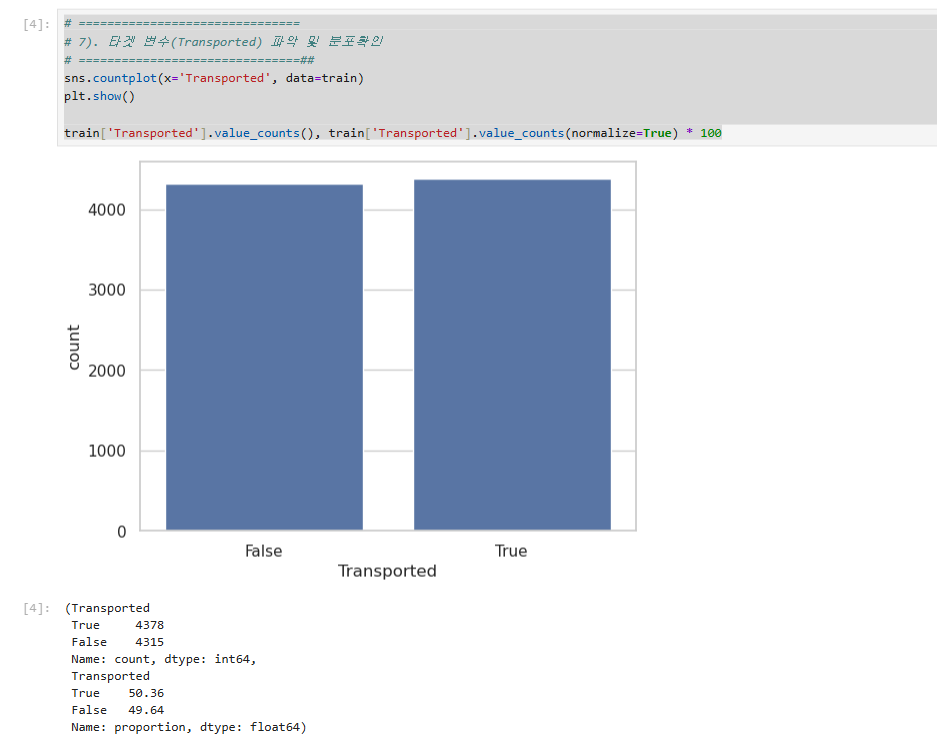


그 이후 타겟 변수와 관련성이 높은 것들이 무엇일지를 Grok, DeepSeek, Gemini에게 질문한 후 인사이트를 얻음
인사이트를 바탕으로 ChatGPT에게 프로젝트 진행 계획을 세우게 하고, 그 방향에 맞춰서 준비단계 + 5단계 절차로 진행함
시스템이 다운되는 몇번의 고비가 있었고, 오류도 많았지만, 워크 플로우가 결정된 후에는 끝까지 진행했음.

중간에 정확도가 82% 이상도 나왔지만, 다양한 방법을 충분히 시도함

즐거운 여행이었습니다. 